# Scraping Data from Transfermarkt and Visualize

### 1. Read Libraries

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

### 2. Building function to scrap data

In [2]:
def Team(sequence):
    #Things we need (Name, Value, Age, Position, Number, Team)
    Player_List = []
    Value_List = []
    Age_List = []
    Position_List = []
    Number_List = []
    Team_List = []
    headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
    for i in range(len(sequence)):
        e = sequence[i]
        # Scraping
        pageTree = requests.get(e, headers=headers)
        pageSoup = BeautifulSoup(pageTree.content, 'html.parser')
        Players = pageSoup.find_all("td", {"class": "hide"})
        Values = pageSoup.find_all("td", {"class": "rechts hauptlink"})
        Age = pageSoup.find_all("td", {"class": "zentriert"})
        Position = pageSoup.find_all("tr")
        Number = pageSoup.find_all("td")
        a = 0
        b = 0 
        c = 1
        d = 4
        e = 3
        while a < len(Players):
            Player_List.append(Players[a].text)
            a = a + 1
            Team_List.append(sequence[i][32:(len(sequence[i])-22)])
        while b < len(Values):
            Value_List.append(Values[b].text)
            b = b + 1
        while c < (1+len(Players)*3):
            Age_List.append(Age[c].text)
            c = c + 3
        while d < (4+len(Players)*3):
            Position_List.append(Position[d].text)
            d = d + 3 
        while e < (3+len(Players)*9):
            Number_List.append(Number[e].text)
            e = e + 9
    # Return these results to dataframe
    Player = pd.DataFrame({'Player':Player_List})
    Value = pd.DataFrame({'Value':Value_List})
    Age = pd.DataFrame({'Age':Age_List})    
    Position = pd.DataFrame({'Position':Position_List})  
    Number = pd.DataFrame({'Number':Number_List})  
    Club = pd.DataFrame({'Club':Team_List})
    return Player, Value, Age, Position, Number, Club

In [3]:
# Scrapping 20 Clubs data
Player,Value,Age, Position, Number, Club = Team(['https://www.transfermarkt.co.uk/manchester-city/startseite/verein/281',
      'https://www.transfermarkt.co.uk/fc-liverpool/startseite/verein/31',
      'https://www.transfermarkt.co.uk/fc-chelsea/startseite/verein/631',
      'https://www.transfermarkt.co.uk/tottenham-hotspur/startseite/verein/148',
      'https://www.transfermarkt.co.uk/fc-arsenal/startseite/verein/11',
      'https://www.transfermarkt.co.uk/manchester-united/startseite/verein/985',
      'https://www.transfermarkt.co.uk/wolverhampton-wanderers/startseite/verein/543',
      'https://www.transfermarkt.co.uk/fc-everton/startseite/verein/29',
      'https://www.transfermarkt.co.uk/leicester-city/startseite/verein/1003',
      'https://www.transfermarkt.co.uk/west-ham-united/startseite/verein/379',
      'https://www.transfermarkt.co.uk/fc-watford/startseite/verein/1010',
      'https://www.transfermarkt.co.uk/crystal-palace/startseite/verein/873',
      'https://www.transfermarkt.co.uk/newcastle-united/startseite/verein/762',
      'https://www.transfermarkt.co.uk/afc-bournemouth/startseite/verein/989',
      'https://www.transfermarkt.co.uk/fc-burnley/startseite/verein/1132',
      'https://www.transfermarkt.co.uk/fc-southampton/startseite/verein/180',
      'https://www.transfermarkt.co.uk/brighton-amp-hove-albion/startseite/verein/1237',
      'https://www.transfermarkt.co.uk/norwich-city/startseite/verein/1123',
      'https://www.transfermarkt.co.uk/sheffield-united/startseite/verein/350',
      'https://www.transfermarkt.co.uk/aston-villa/startseite/verein/405'])

In [4]:
# Join Together
EPL =  Player.join(Value).join(Age).join(Position).join(Number).join(Club)


In [5]:
# Transform player value to float for further analysis
EPL[['Value']] = pd.concat([Value[col].str.split()
                       .str[0]
                       .str.replace('£','')
                       .str.replace('k','000')
                       .str.replace('m','').astype(float) for col in Value], axis=1)

In [6]:
Filter = EPL[EPL.Value>200].copy(deep=False)
Filter['Value'] = Filter['Value'].div(1000000).round(2)
EPL[EPL.Value>200] = Filter

In [7]:
# Transform player birth date and age to age (numeric)
Ranking = EPL.sort_values('Value',ascending = False).reset_index(drop = 'True')
Age = Ranking['Age'].str[-3:-1]
Ranking['Age'] = Age.astype(int)

#### A slight change on clubs name

In [8]:
# Some names are spelled in a wrong way
Ranking['Club'].unique()

array(['manchester-city', 'tottenham-hotspur', 'fc-liverpoo',
       'fc-chelsea', 'manchester-united', 'fc-arsena', 'fc-everto',
       'leicester-city/', 'crystal-palace', 'west-ham-united',
       'wolverhampton-wanderers', 'aston-villa', 'afc-bournemouth',
       'newcastle-united', 'fc-watford/', 'fc-burnley/',
       'brighton-amp-hove-albion/', 'fc-southampton', 'norwich-city/',
       'sheffield-united'], dtype=object)

In [9]:
# Replace them
Ranking.Club.replace(['tottenham-hotspur','fc-liverpoo','fc-arsena','fc-everto','leicester-city/',
                      'fc-watford/','fc-burnley/','brighton-amp-hove-albion/','norwich-city/'],
                     ['tottenham-hotspurs','fc-liverpool','fc-arsenal','fc-everton','leicester-city',
                      'fc-watford','fc-burnley','brighton-amp-hove-albion','norwich-city'],inplace=True)

#### Scrap Nationality

In [10]:
Ranking.Player[0]

'Raheem Sterling'

In [19]:
def Citizenship(x):
    headers = {'User-Agent': 
           'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}
    Country = []
    i = 0
    while i < len(x.Player):
        player = x.Player[i]
        data = requests.get("https://www.transfermarkt.com/schnellsuche/ergebnis/schnellsuche?query={}&x=0&y=0".format(player),headers=headers) 
        soup = BeautifulSoup(data.text, "lxml")
        hrefs = soup.find_all("img", {"class" : "flaggenrahmen"},alt=True)
        Flag = hrefs[16]['alt']
        Country.append(Flag)
        i = i+1
    return Country



In [20]:
Citizenship = Citizenship(Ranking)

In [21]:
Ranking = Ranking.join(pd.DataFrame({'Citizenship':Citizenship}))

However, the algorithm behind scraping citizenship is using search. Most of the nationality is right, however, some popular Portuguese and Spanish names tend to make noises (e.g Rodri, Pedro, Bernardo). So To make sure this scraping country works, I need to check it again.

In [50]:
Ranking.loc[Ranking['Player'] == 'Rodri', ['Citizenship']] = 'Spain'
Ranking.Citizenship.replace(['Korea, South'],['South Korea'],inplace = True)
Ranking.loc[Ranking['Player'] == 'Fred', ['Citizenship']] = 'Brazil'
Ranking.loc[Ranking['Player'] == 'Bernard', ['Citizenship']] = 'Brazil'
Ranking.loc[Ranking['Player'] == 'Pedro', ['Citizenship']] = 'Spain'
Ranking.loc[Ranking['Player'] == 'Bernardo', ['Citizenship']] = 'Brazil'
Ranking.loc[Ranking['Player'] == 'Roberto', ['Citizenship']] = 'Spain'
Ranking.loc[Ranking['Player'] == 'Nathan', ['Citizenship']] = 'Brazil'



#### Final version of data

In [51]:
pd.set_option('display.max_rows', 1000)
Ranking

,Player,Value,Age,Position,Number,Club,Citizenship
0,Raheem Sterling,144.00,25,Left Winger,7,manchester-city,England
1,Harry Kane,135.00,26,Centre-Forward,10,tottenham-hotspurs,England
2,Mohamed Salah,135.00,27,Right Winger,11,fc-liverpool,Egypt
3,Sadio Mané,135.00,27,Left Winger,10,fc-liverpool,Senegal
4,Kevin De Bruyne,135.00,28,Attacking Midfield,17,manchester-city,Belgium
5,Trent Alexander-Arnold,99.00,21,Right-Back,66,fc-liverpool,England
6,Virgil van Dijk,90.00,28,Centre-Back,4,fc-liverpool,Netherlands
7,N'Golo Kanté,90.00,28,Central Midfield,7,fc-chelsea,France
8,Bernardo Silva,90.00,25,Right Winger,20,manchester-city,Portugal
9,Leroy Sané,90.00,23,Left Winger,19,manchester-city,Germany


### 3. Data Visualization

#### The descriptive Statistics of Age

In [52]:
Ranking['Age'].describe()

count    524.000000
mean      26.557252
std        4.201721
min       18.000000
25%       23.000000
50%       27.000000
75%       30.000000
max       39.000000
Name: Age, dtype: float64

#### Top 10 Players with highest values

In [53]:
Ranking.sort_values("Value",ascending = False).reset_index(drop = 'True').iloc[:10,]

,Player,Value,Age,Position,Number,Club,Citizenship
0,Raheem Sterling,144.0,25,Left Winger,7,manchester-city,England
1,Mohamed Salah,135.0,27,Right Winger,11,fc-liverpool,Egypt
2,Sadio Mané,135.0,27,Left Winger,10,fc-liverpool,Senegal
3,Kevin De Bruyne,135.0,28,Attacking Midfield,17,manchester-city,Belgium
4,Harry Kane,135.0,26,Centre-Forward,10,tottenham-hotspurs,England
5,Trent Alexander-Arnold,99.0,21,Right-Back,66,fc-liverpool,England
6,Virgil van Dijk,90.0,28,Centre-Back,4,fc-liverpool,Netherlands
7,N'Golo Kanté,90.0,28,Central Midfield,7,fc-chelsea,France
8,Bernardo Silva,90.0,25,Right Winger,20,manchester-city,Portugal
9,Leroy Sané,90.0,23,Left Winger,19,manchester-city,Germany


#### Players Age Distribution

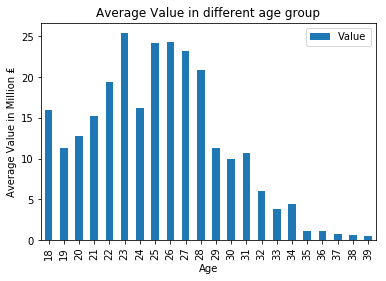

In [54]:
Ranking.groupby('Age')[['Value']].mean().plot.bar()
plt.xlabel('Age')
plt.ylabel('Average Value in Million ₤')
plt.title('Average Value in different age group')
plt.show()

#### Clubs Value Ranking 

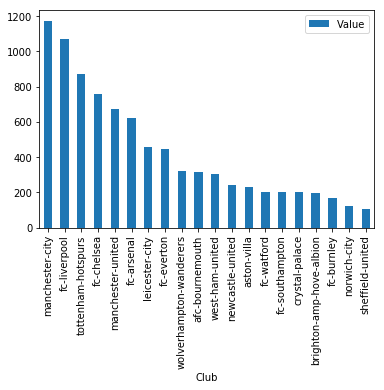

In [55]:
Ranking.groupby('Club')[['Value']].sum().sort_values('Value',ascending = False).plot.bar()

Number of Players from different countries

In [67]:
Ranking.groupby('Citizenship')[['Player']].count().sort_values('Player',ascending = False)

,Player
Citizenship,
England,182
France,29
Spain,27
Ireland,21
Brazil,21
Netherlands,18
Portugal,17
Argentina,16
Wales,14
